<a href="https://colab.research.google.com/github/CryptoManiacMS/colab/blob/main/flux-img-generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 STEP 1

In [1]:
# ✅ Remove qualquer versão antiga ou corrompida do repositório
!rm -rf /content/TotoroUI

# ✅ Remove possíveis restos bugados do torch
!rm -rf /usr/local/lib/python3.11/dist-packages/~orch*

# ✅ Limpa cache do pip (boa prática no Colab)
!pip cache purge

Files removed: 0


## 🚀 STEP 2

### Reinicie o ambiente de execução neste ponto!
### > Menu: Ambiente de execução > Reiniciar ambiente de execução
### ✅ Depois que o ambiente reiniciar, volte aqui e rode tudo abaixo:

In [2]:
# ✅ Clona o repositório limpo
%cd /content
!git clone -b totoro3 https://github.com/camenduru/ComfyUI /content/TotoroUI
%cd /content/TotoroUI

# ✅ Instala as dependências corretas (versões compatíveis)
!pip install -q torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 \
  torchsde einops diffusers accelerate xformers==0.0.28.post2

# ✅ Instala o aria2 para fazer downloads rápidos dos modelos
!apt -y install -qq aria2

# ✅ Baixa os modelos necessários
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M \
  https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors \
  -d /content/TotoroUI/models/unet -o flux1-dev-fp8.safetensors

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M \
  https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft \
  -d /content/TotoroUI/models/vae -o ae.sft

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M \
  https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors \
  -d /content/TotoroUI/models/clip -o clip_l.safetensors

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M \
  https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors \
  -d /content/TotoroUI/models/clip -o t5xxl_fp8_e4m3fn.safetensors


/content
Cloning into '/content/TotoroUI'...
remote: Enumerating objects: 14652, done.
remote: Total 14652 (delta 0), reused 0 (delta 0), pack-reused 14652 (from 1)
Receiving objects: 100% (14652/14652), 21.13 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (9823/9823), done.
/content/TotoroUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta

# 🚀 STEP 3

In [3]:
# Vai para a pasta do projeto
%cd /content/TotoroUI

# Importa os módulos necessários
import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management
from IPython.display import display

# Prepara os loaders
DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

# Carrega os modelos
with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

# Função auxiliar pra garantir tamanho múltiplo de 16
def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    n2 = m * (q + 1) if (n * m) > 0 else m * (q - 1)
    return n1 if abs(n - n1) < abs(n - n2) else n2

/content/TotoroUI


# 🚀 STEP 4

## Configurações:

- positive_prompt: Aqui você insere o prompt desejado
- width, height: Dimensões da imagem a ser gerada
- steps: Quantidade de etapas de refinamento
  - 10~20 steps → rápido, rascunho ou testes.
  - 30~50 steps → boa qualidade geral.
  - 60~100+ steps → alta qualidade, mas demora mais.

- sampler_name:

| Nome              | O que faz                                                  | Quando usar                                                         |
| ----------------- | ---------------------------------------------------------- | ------------------------------------------------------------------- |
| `euler`           | Simples e rápido. Boa qualidade, linhas mais suaves.       | Uso geral, imagens que não precisam de muitos detalhes finos.       |
| `euler_ancestral` | Mais aleatório, resultados mais variados e criativos.      | Quando quer diversidade nas saídas.                                 |
| `heun`            | Variante do Euler, mais estável.                           | Para gerar imagens consistentes e detalhadas.                       |
| `lms`             | Linear multistep, bom para detalhes e precisão.            | Quando quer alta fidelidade ao prompt.                              |
| `dpm_2`           | Difusion probabilística, 2ª ordem. Mais preciso que Euler. | Boa escolha para alta qualidade em menos steps.                     |
| `dpm_2_ancestral` | Versão ancestral do DPM 2, mais diversidade no output.     | Para resultados mais criativos.                                     |
| `dpm_fast`        | Focado em performance, gera mais rápido.                   | Quando quer testar rápido sem se importar com a qualidade final.    |
| `dpm_adaptive`    | Ajusta dinamicamente o passo da difusão.                   | Quando quer otimização automática, especialmente em alta resolução. |


- scheduler

| Nome          | O que faz                         | Quando usar                             |
| ------------- | --------------------------------- | --------------------------------------- |
| `simple`      | Linear simples, padrão no Totoro. | Quase sempre serve bem.                 |
| `exponential` | Decaimento exponencial do ruído.  | Para outputs mais suaves.               |
| `polynomial`  | Curva polinomial para ruído.      | Para ajustes finos em detalhes.         |
| `cosine`      | Variação em formato de onda.      | Para detalhes complexos ou luz natural. |
| `karras`      | Baseado nos métodos de Karras.    | Alta qualidade em menos steps.          |


<br><br>
# 💡Dicas de uso

| Sampler           | Scheduler    | Quando usar                              | Dica extra                                           |
| ----------------- | ------------ | ---------------------------------------- | ---------------------------------------------------- |
| `euler`           | `simple`     | Rápido, boa qualidade geral              | Comece por aqui pra ajustes básicos no prompt        |
| `euler_ancestral` | `cosine`     | Criatividade e variação                  | Ótimo pra cenas artísticas e concept art             |
| `heun`            | `karras`     | Detalhes nítidos, estabilidade           | Use em retratos e close-ups                          |
| `dpm_2`           | `polynomial` | Alta fidelidade ao prompt                | Bom pra gerar logos, textos, imagens clean           |
| `dpm_2_ancestral` | `cosine`     | Criativo + detalhado                     | Ideal pra cenários complexos e iluminação realista   |
| `dpm_adaptive`    | `karras`     | Otimização e qualidade em alta resolução | Para gerar grandes imagens sem precisar muitos steps |
| `dpm_fast`        | `simple`     | Testes rápidos                           | Só pra preview, qualidade menor                      |


Seed usado: 17041098440808685288


  0%|          | 0/300 [00:00<?, ?it/s]

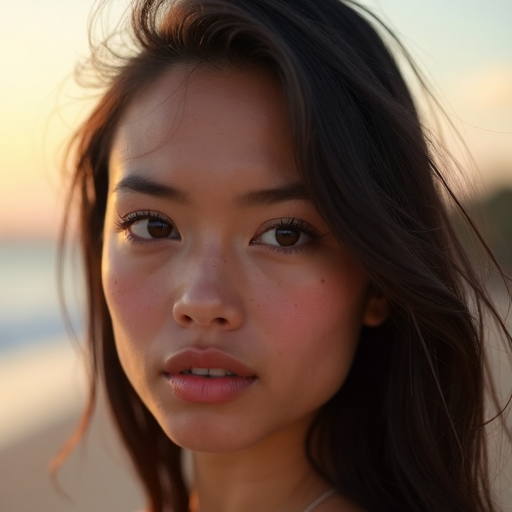

In [4]:
# Gera a imagem
with torch.inference_mode():
    positive_prompt = "Realistic portrait of a young woman around 26 years old, light brown skin with natural texture and subtle imperfections, oval face with soft, human-like contours, long straight dark brown hair with a few loose and slightly messy strands, large dark brown eyes with a warm, relaxed gaze, full pink lips with slight asymmetry, gentle confident expression, soft natural sunset lighting, slightly blurred beach background, visible skin pores, slight unevenness in hair and features, high-resolution natural photography style, unretouched."
    width = 512
    height = 512
    sampler_name = "ddim"
    scheduler = "karras"
    seed = 17041098440808685288 # random.randint(0, 18446744073709551615)
    steps = 300

    print(f"Seed usado: {seed}")

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]

    noise = RandomNoise.get_noise(seed)[0]
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)

    model_management.soft_empty_cache()

    decoded = VAEDecode.decode(vae, sample)[0].detach()

    # Salva a imagem
    Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0]).save("/content/flux.png")

    # Exibe no notebook
    display(Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0]))